### Helpful Links
- https://stats.stackexchange.com/questions/276497/maximum-mean-discrepancy-distance-distribution
- https://stats.stackexchange.com/questions/405355/does-the-jensen-shannon-divergence-maximise-likelihood
- https://www.kaggle.com/meaninglesslives/understanding-kl-divergence
- https://h1ros.github.io/posts/loss-functions-in-deep-learning-with-pytorch/

### To Study
- https://cs.nyu.edu/courses/spring18/CSCI-GA.3033-022/

In [1]:
import numpy as np
import torch
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt

# for animation
%matplotlib inline
import matplotlib.animation
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

from typing import Dict, List, Tuple

In [2]:
mu1,sigma1 = -5,1
mu2,sigma2 = 10,1

gaussian1 = torch.distributions.Normal(mu1,sigma1) 
gaussian2 = torch.distributions.Normal(mu2,sigma2)

Text(0.5, 1.0, '$Q(X)$')

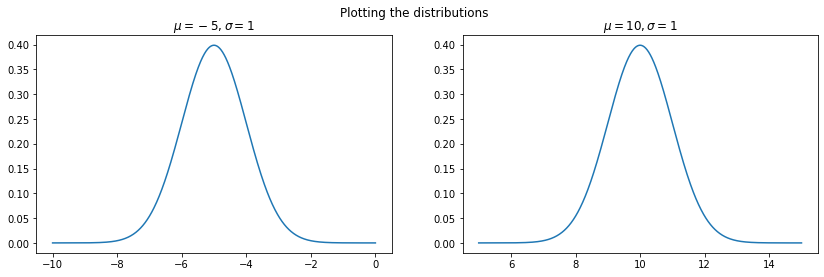

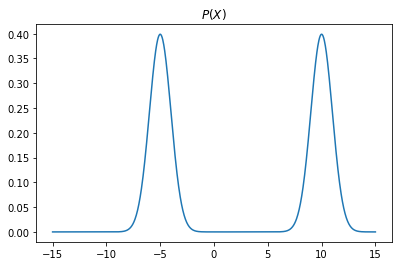

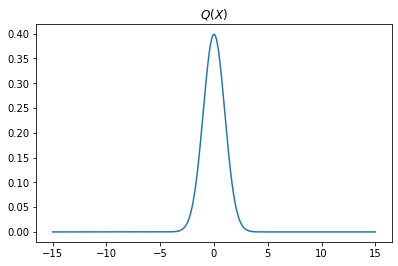

In [101]:
plt.figure(figsize=(14,4))
x = torch.linspace(mu1-5*sigma1,mu1+5*sigma1,1000)
plt.subplot(1,2,1)
plt.plot(x.numpy(),gaussian1.log_prob(x).exp().numpy())
plt.title(f'$\mu={mu1},\sigma={sigma1}$')

x = torch.linspace(mu2-5*sigma2,mu2+5*sigma2,1000)
plt.subplot(1,2,2)
plt.plot(x.numpy(),gaussian2.log_prob(x).exp().numpy())
plt.title(f'$\mu={mu2},\sigma={sigma2}$')

plt.suptitle('Plotting the distributions')

plt.figure(figsize=(14,4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
plt.subplot(1,2,2)
plt.plot(x.numpy(),px.numpy())
plt.title('$P(X)$')

mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

plt.figure(figsize=(14,4))
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
Q = torch.distributions.Normal(mu,sigma) # this should approximate P, eventually :-)
qx = Q.log_prob(x).exp()
plt.subplot(1,2,2)
plt.plot(x.numpy(),qx.detach().numpy())
plt.title('$Q(X)$')

In [96]:
def optimize_loss(px, muq, sigmaq, reverse = False):
    
    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)    
    opt = torch.optim.Adam([mu,sigma])
    loss_val = []
    all_mu = []
    epochs = 10000
    criterion = torch.nn.KLDivLoss()
    for i in range(epochs):
        Q = torch.distributions.Normal(mu,sigma)
        if reverse:
            qx = Q.log_prob(x).exp()
            loss = criterion(px.log(), qx)
        else:
            qx = Q.log_prob(x).exp()
            loss = criterion(qx, px)

        #backward pass
        opt.zero_grad()
        loss.backward()    
        opt.step()
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])
        
        if i%(epochs//10)==0:
            print('Epoch:',i,'Loss:',loss.data.numpy(),'mu',mu.data.numpy()[0],'sigma',sigma.data.numpy()[0])

    print('Epoch:',i,'Loss:',loss.data.numpy(),'mu',mu.data.numpy()[0],'sigma',sigma.data.numpy()[0])
    
    plt.figure(figsize=(14,6))
    plt.subplot(2,2,1)
    plt.plot(loss_val)
    plt.xlabel('epoch')
    plt.ylabel(f'Loss')
    plt.title(f'Loss vs epoch')
    
    plt.subplot(2,2,2)
    plt.plot(all_mu)
    plt.xlabel('epoch')
    plt.ylabel('$\mu$')
    plt.title('$\mu$ vs epoch')
    
    return mu.data.numpy()[0], sigma.data.numpy()[0]

### Optimizing on KL Divergence

Epoch: 0 Loss: 2.2151053 mu -0.0009999999 sigma 1.001
Epoch: 1000 Loss: 0.67496186 mu 0.022481997 sigma 1.9919174
Epoch: 2000 Loss: 0.4676995 mu 0.5450262 sigma 2.5654833
Epoch: 3000 Loss: 0.3868703 mu 0.9762871 sigma 3.0174146
Epoch: 4000 Loss: 0.34232643 mu 1.3582242 sigma 3.436633
Epoch: 5000 Loss: 0.3144534 mu 1.6972711 sigma 3.849976
Epoch: 6000 Loss: 0.2959502 mu 1.9883032 sigma 4.2688804
Epoch: 7000 Loss: 0.28332257 mu 2.222481 sigma 4.6978326
Epoch: 8000 Loss: 0.2746169 mu 2.3948417 sigma 5.1371346
Epoch: 9000 Loss: 0.26863497 mu 2.511753 sigma 5.5840044
Epoch: 9999 Loss: 0.26459852 mu 2.5920448 sigma 6.0326486


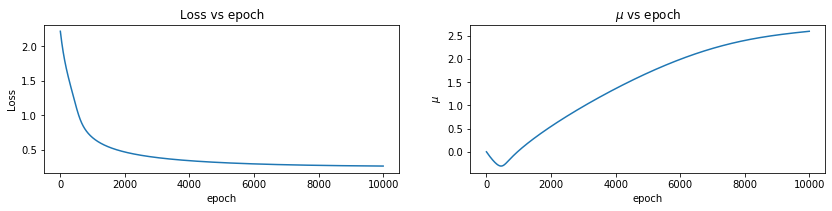

In [97]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma = optimize_loss(px, muq = 0.0, sigmaq = 1.0)

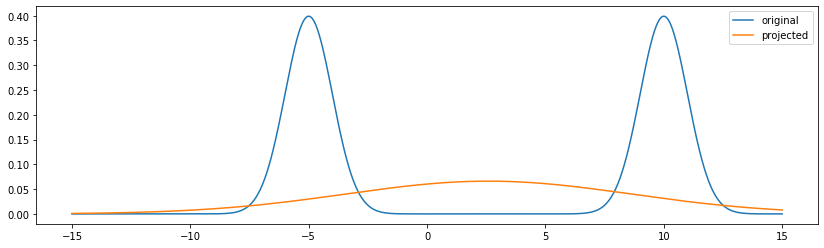

In [98]:
Q = torch.distributions.Normal(mu,sigma) 
qx = Q.log_prob(x).exp()

plt.figure(figsize=(14,4))
plt.plot(x.numpy(),px.numpy(), label = 'original')
plt.plot(x.numpy(), qx.numpy(), label = 'projected')
plt.legend()

### Optimizing on Reverse KL Divergence

Epoch: 0 Loss: 0.4151832 mu -0.0009999999 sigma 1.001
Epoch: 1000 Loss: 0.27149484 mu -0.9625565 sigma 1.0108246
Epoch: 2000 Loss: 0.16609436 mu -1.8424077 sigma 1.0002983
Epoch: 3000 Loss: 0.09251768 mu -2.643515 sigma 1.000007
Epoch: 4000 Loss: 0.04449686 mu -3.3659055 sigma 1.0000005
Epoch: 5000 Loss: 0.016895583 mu -3.9932222 sigma 1.0000001
Epoch: 6000 Loss: 0.004297466 mu -4.492379 sigma 1.0
Epoch: 7000 Loss: 0.0005360601 mu -4.8208013 sigma 1.0
Epoch: 8000 Loss: 1.8624063e-05 mu -4.9666266 sigma 1.0
Epoch: 9000 Loss: 7.011105e-08 mu -4.9979544 sigma 1.0
Epoch: 9999 Loss: -2.6522468e-10 mu -4.999959 sigma 1.0


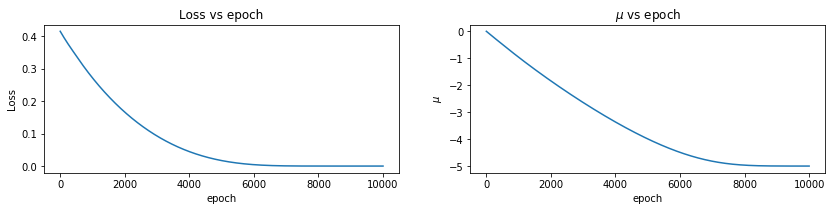

In [88]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2,mu1+mu2+5*sigma1+5*sigma2,1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu,sigma = optimize_loss(px, muq = 0.0, sigmaq = 1.0, reverse = True)

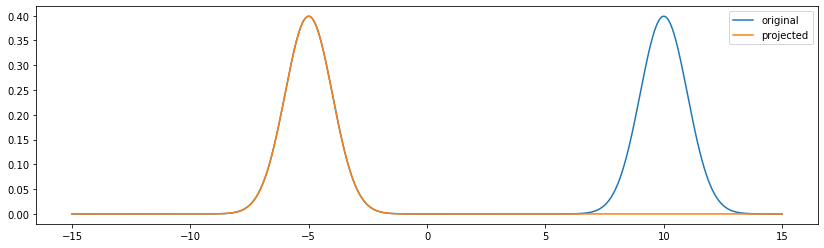

In [89]:
Q = torch.distributions.Normal(mu,sigma) 
qx = Q.log_prob(x).exp()

plt.figure(figsize=(14,4))
plt.plot(x.numpy(),px.numpy(), label = 'original')
plt.plot(x.numpy(), qx.numpy(), label = 'projected')
plt.legend()